In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv("titanic.csv", index_col="PassengerId")
df.drop(columns=["Name", "Ticket", "Cabin"], inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


## Exploratory Data Analysis

### Target

In [3]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Numeric vs Target

C:\anaconda\envs\course1\lib\site-packages\statsmodels\nonparametric\kde.py:547: RuntimeWarning: invalid value encountered in greater
  x = x[np.logical_and(x > clip[0], x < clip[1])]
C:\anaconda\envs\course1\lib\site-packages\statsmodels\nonparametric\kde.py:547: RuntimeWarning: invalid value encountered in less
  x = x[np.logical_and(x > clip[0], x < clip[1])]


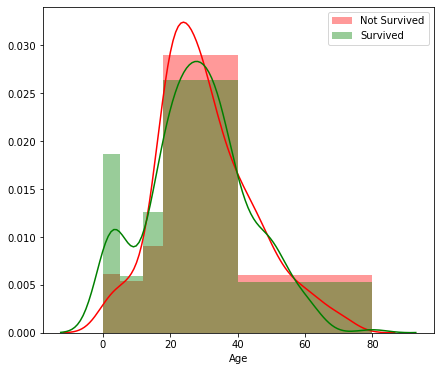

In [4]:
plt.figure(figsize=[7,6])
sns.distplot(df.Age[df.Survived == 0], bins=[0,5,12,18,40,df.Age.max()], color="r", label="Not Survived")
sns.distplot(df.Age[df.Survived == 1], bins=[0,5,12,18,40,df.Age.max()], color="g", label="Survived")
plt.legend()

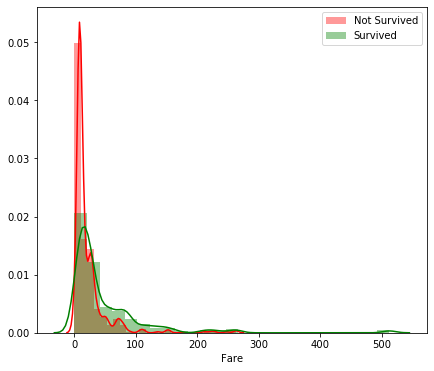

In [5]:
plt.figure(figsize=[7,6])
sns.distplot(df.Fare[df.Survived == 0], bins=25, color="r", label="Not Survived")
sns.distplot(df.Fare[df.Survived == 1], bins=25, color="g", label="Survived")
plt.legend()

### Categoric / Ordinal vs Target

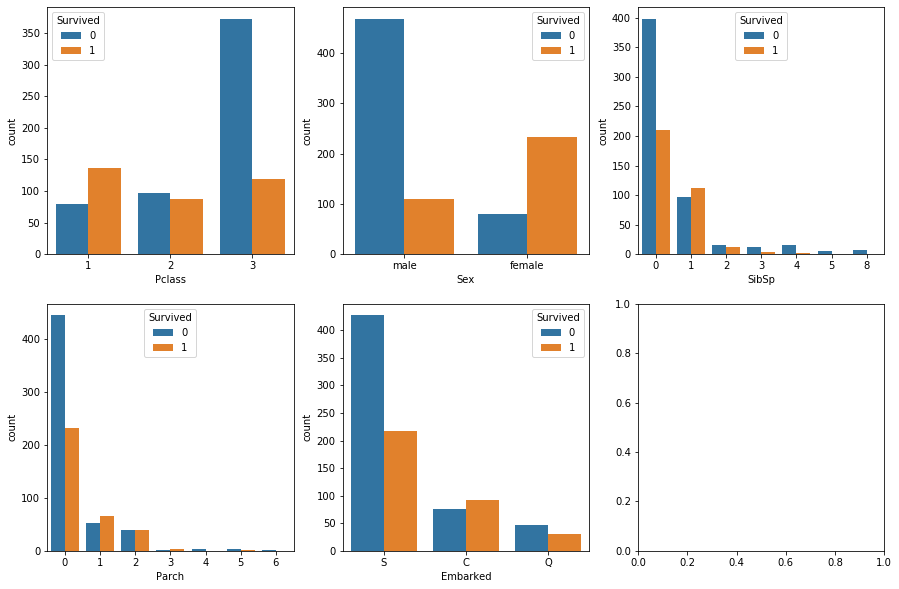

In [6]:
cat_var = ["Pclass","Sex","SibSp","Parch","Embarked"]
fig, axes = plt.subplots(2,3, figsize=(15,10))
for cat, ax in zip(cat_var, axes.flatten()):
    sns.countplot(cat, data=df, hue="Survived", ax=ax)

### Pandas crosstab (optional)

In [7]:
pd.crosstab(df.Pclass, df.Survived, normalize="index")

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


## Feature Engineering

### Adding feature => isAlone (menambahkan kolom baru isAlone)

In [8]:
df["isAlone"] = (df["Parch"] == 0) & (df["SibSp"] == 0)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,False
2,1,1,female,38.0,1,0,71.2833,C,False
3,1,3,female,26.0,0,0,7.9250,S,True
4,1,1,female,35.0,1,0,53.1000,S,False
5,0,3,male,35.0,0,0,8.0500,S,True


### Binning

In [9]:
df.Age = pd.cut(df.Age, [0,5,12,18,40,120], labels=["balita", "anak-anak", "remaja", "dewasa", "lansia"])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,dewasa,1,0,7.2500,S,False
2,1,1,female,dewasa,1,0,71.2833,C,False
3,1,3,female,dewasa,0,0,7.9250,S,True
4,1,1,female,dewasa,1,0,53.1000,S,False
5,0,3,male,dewasa,0,0,8.0500,S,True


In [10]:
df.Fare = pd.cut(df.Fare, [0,25,100,600], labels=["murah", "mahal", "eksekutif"])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,dewasa,1,0,murah,S,False
2,1,1,female,dewasa,1,0,mahal,C,False
3,1,3,female,dewasa,0,0,murah,S,True
4,1,1,female,dewasa,1,0,mahal,S,False
5,0,3,male,dewasa,0,0,murah,S,True


# Dataset Splitting

In [11]:
X = df.drop(columns=["Survived"])
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 8), (179, 8), (712,), (179,))

### Preprocessor

In [28]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'isAlone'],
      dtype='object')

In [29]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
#preprocessor
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ("numeric", numerical_pipeline, ["SibSp","Parch"]),
    ("categoric", categorical_pipeline, ["Pclass","Sex","Fare","Embarked","isAlone","Age"])
])


### Training

In [30]:
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", KNeighborsClassifier())
])

parameter = {
    "algo__n_neighbors": range(1,51,2),
    "algo__weights": ["uniform","distance"],
    "algo__p": [1,2]
}

model = GridSearchCV(pipeline, parameter, cv=3, verbose=1, n_jobs=1)
model.fit(X_train,y_train)

#evaluation
print(model.best_params_)
print(model.score(X_train,y_train), model.best_score_, model.score(X_test,y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'algo__n_neighbors': 25, 'algo__p': 2, 'algo__weights': 'distance'}
0.8792134831460674 0.8146237397912751 0.7988826815642458


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   13.1s finished
